# Compartmental Models

[1-2 sentences introducing compartmental models. What are they for?]

## SIR Model

The SIR model can be described by the following ODEs:
- $\frac{dS}{dt} = -\frac{\beta I S}{N}$
- $\frac{dI}{dt} = \frac{\beta I S}{N} - \gamma I$
- $\frac{dR}{dt} = \gamma I$

The variables:
- $S$ represents the number of susceptible individuals
- $I$ represents the number of infected individuals
- $R$ represents the number of recovered individuals
- $N$ is the total population size

The parameters:
- $\beta$ represents the transmission rate
- $\gamma$ represents the recovery rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [4]:
# SIR computational model
def sir_model(
    y,      # a tuple with (S, I, R)
    t, 
    transmission_rate, # beta
    recovery_rate,     # gamma
):
    S, I, R = y
    N = S + I + R
    dSdt = -transmission_rate * S * I / N
    dIdt = transmission_rate * S * I / N - recovery_rate * I
    dRdt = recovery_rate * I
    return dSdt, dIdt, dRdt
    

In [35]:
# initial comditions

## Total population
N = 1000
I0 = 1
R0 = 0
S0 = N - I0 - R0
y0 = S0, I0, R0  # put the population in a tuple
transmission_rate = 0.4  # transmission rate
recovery_rate = 0.1  # recovery rate

# time points (in days)
t = np.linspace(0, 365, 365)

# simulate with odeint
soln = odeint(sir_model, y0, t, args=(transmission_rate, recovery_rate))
S, I, R = soln.T

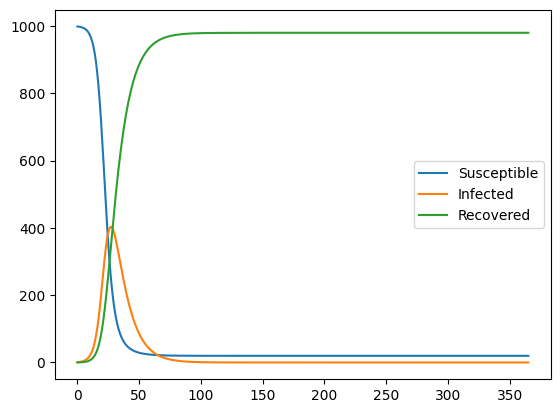

In [36]:
# plotting
plt.figure()
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.legend()
# TODO -- add title xlabel, ylabel

## Extending the SIR model to include Spatial Dynamics
[2 sentences explaining what this is for]

### Spatial Models
we divide the population into regions (or compartments). Each compartment has its own S, I, R populations, and the disease can spread within and between these compartments. This allows us to model spread over time and over space

## generic SIR model for any number of regions

In [ ]:
def generic_spatial_sir(
    y,                 # all populations, including S, I, R for each location
    t, 
    N,                 # list of population at each location
    infection_rate, 
    recovery_rate, 
    migration_matrix,  # represents movement between regions (len(N)xlen(N) matrix)
):
    num_regions = len(N)
    derivatives = np.zeros(num_regions * 3)  # initialize all derivatives

    for loc in range(num_regions):
        S, I, R = y[loc*3:(loc+1)*3]  # extract S, I, R for this location

        # Calculate net movement for susceptible and infected individuals
        net_S_movement = sum(
            migration_matrix[j][loc] * y[j*3] - migration_matrix[loc][j] * S for j in range(num_regions))
        net_I_movement = sum(
            migration_matrix[j][loc] * y[j*3+1] - migration_matrix[loc][j] * I for j in range(num_regions))
        net_R_movement = sum(
            migration_matrix[j][loc] * y[j*3+2] - migration_matrix[loc][j] * R for j in range(num_regions))

        # SIR model equations with mobility
        dSdt = -infection_rate[loc] * S * I / N[loc] + net_S_movement
        dIdt = infection_rate[loc] * S * I / N[loc] - recovery_rate[loc] * I + net_I_movement
        dRdt = recovery_rate[loc] * I + net_R_movement
        
        # Update derivatives
        derivatives[loc*3:(loc+1)*3] = [dSdt, dIdt, dRdt]

    return derivatives

N = [1000, 5000]  # Denver, Chicago population

migration_matrix = [
    [0, 0.1],  # movement from Denver to Chicago
    [0.2, 0]
]

# y is a list of all SIR for each region
y = [0_S, 0_I, 0_R, 1_S, 1_I, 1_R, ...]